In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # ca

Text(0,0.5,'Magnitud')

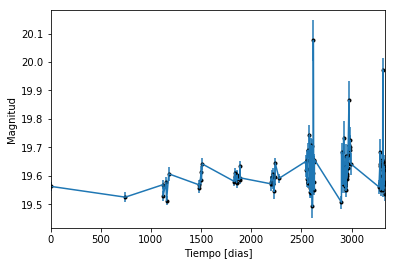

In [7]:
data = np.genfromtxt('LC_R_32769.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')

In [3]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [4]:
%%capture capt
sample = model.run_mcmc(20000)

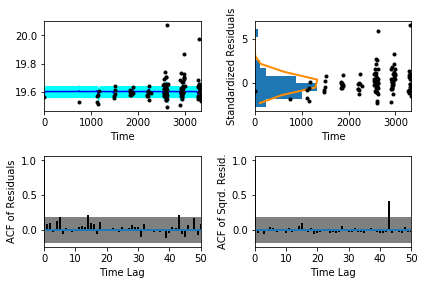

In [5]:
sample.assess_fit()

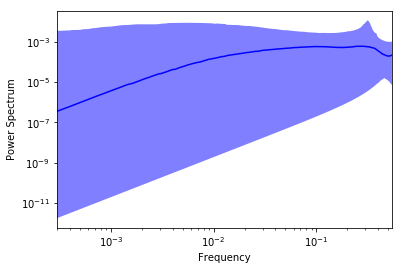

In [8]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

In [16]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

ValueError: zero-size array to reduction operation maximum which has no identity

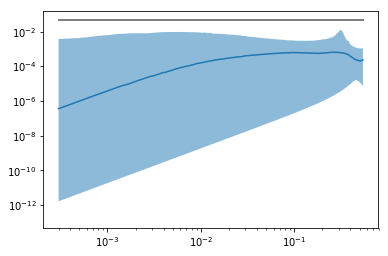

In [29]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 1000000000000.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Prediccion , valor esperado ')

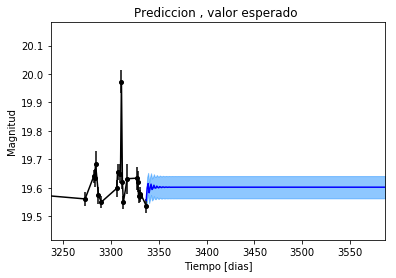

In [33]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')
plt.title('Prediccion , valor esperado ')

Text(0.5,1,'Prediccion, Caminos simulados')

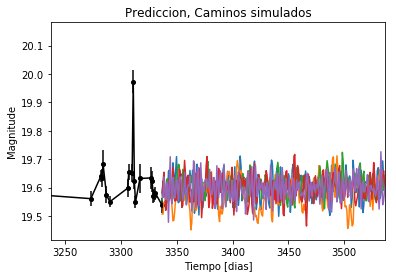

In [34]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Prediccion, Caminos simulados')

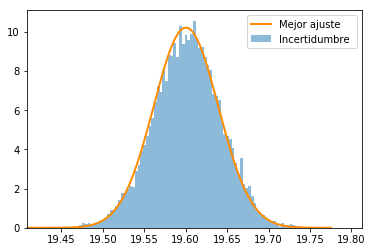

In [36]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Incertidumbre ')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Mejor ajuste ')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

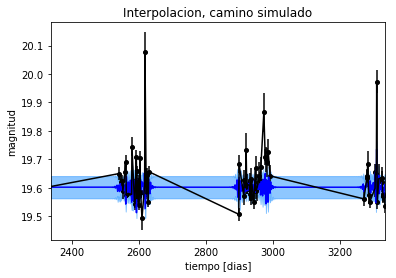

In [37]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

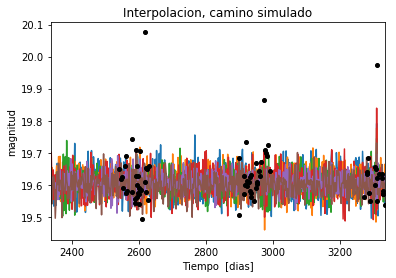

In [38]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

In [39]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

In [40]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [41]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 193.510874847
Median: 0.701817723894
Standard deviation: 0.2680065499
68% credibility interval: [ 0.32093314  0.97374511]
95% credibility interval: [ 0.24716388  1.07118426]
99% credibility interval: [ 0.         1.0838039]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 193.510874847
Median: 0.701817723894
Standard deviation: 0.2680065499
68% credibility interval: [ 0.32093314  0.97374511]
95% credibility interval: [ 0.24716388  1.07118426]
99% credibility interval: [ 0.         1.0838039]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 410.138726543
Median: 0.0186255509305
Standard deviation: 0.270498803778
68% cre

Plotting parameter summary


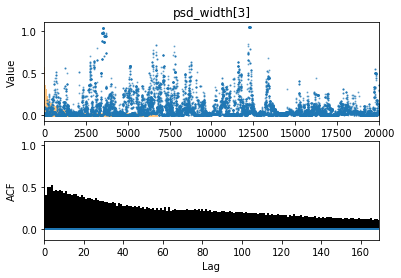

In [42]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [43]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [44]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 982.841404063
Median: 227.262982525
Standard deviation: 1.82435513649
68% credibility interval: [ 225.27918372  228.82975982]
95% credibility interval: [ 222.87295571  229.92893002]
99% credibility interval: [ 221.08535535  230.56848194]


In [45]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [46]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 164.515250269
Median: 3.00804589972
Standard deviation: 3.88104969289
68% credibility interval: [ 0.94235224  8.37529843]
95% credibility interval: [  0.35728792  13.75995702]
99% credibility interval: [  0.20297223  16.92170788]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 144.344413473
Median: 26.6031268454
Standard deviation: 27.3463878958
68% credibility interval: [  6.34464177  61.74712515]
95% credibility interval: [   4.206266

In [47]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [48]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 497.580998672
Median: 3.97235189203e+16
Standard deviation: 1.21642086507e+99
68% credibility interval: [  2.14247135e+02   2.89814394e+85]
95% credibility interval: [  4.59106524e-31   3.39399511e+95]
99% credibility interval: [  1.82534490e-63   1.08678137e+99]


In [49]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [50]:
sample.posterior_summaries('mu')

Calculating effective number of samples
Posterior summary for parameter mu  element 0
----------------------------------------------
Effective number of independent samples: 1688.97667433
Median: 19.6030916756
Standard deviation: 0.00518208184869
68% credibility interval: [ 19.59832547  19.6078419 ]
95% credibility interval: [ 19.59309285  19.61279593]
99% credibility interval: [ 19.581478   19.6159854]


In [51]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [52]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 193.510874847
Median: 0.701817723894
Standard deviation: 0.2680065499
68% credibility interval: [ 0.32093314  0.97374511]
95% credibility interval: [ 0.24716388  1.07118426]
99% credibility interval: [ 0.         1.0838039]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 193.510874847
Median: 0.701817723894
Standard deviation: 0.2680065499
68% credibility interval: [ 0.32093314  0.97374511]
95% credibility interval: [ 0.24716388  1.07118426]
99% credibility interval: [ 0.         1.0838039]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 410.138726543
Median: 0.0186255509305
Standard deviation: 0.270498803778
68% cre

In [53]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [54]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 982.841404063
Median: 227.262982525
Standard deviation: 1.82435513649
68% credibility interval: [ 225.27918372  228.82975982]
95% credibility interval: [ 222.87295571  229.92893002]
99% credibility interval: [ 221.08535535  230.56848194]


In [55]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [56]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 338.123676239
Median: 0.0759463468921
Standard deviation: 0.251408980742
68% credibility interval: [ 0.02149478  0.35447902]
95% credibility interval: [ 0.00698956  0.99623833]
99% credibility interval: [ 0.00116007  1.07657707]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 320.835490638
Median: 0.0757958061898
Standard deviation: 0.247137641776
68% credibility interval: [ 0.02149478  0.34595289]
95% credibility interval: [ 0.00698956  0.99623833]
99% credibility interval: [ 0.00116007  1.07657707]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 497.446310555
Median: 0.133425336386
Standard deviation: 0.274245765895
68% cre

In [57]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [58]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 1299.35748199
Median: 0.00159283511097
Standard deviation: 0.000506806906894
68% credibility interval: [ 0.00115467  0.00213817]
95% credibility interval: [ 0.00083858  0.00279917]
99% credibility interval: [ 0.0006446   0.00331962]


In [59]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [60]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 819.170452141
Median: 1.85253903766
Standard deviation: 0.163808076602
68% credibility interval: [ 1.63937579  1.96459971]
95% credibility interval: [ 1.39812731  1.99399886]
99% credibility interval: [ 1.26270023  1.99915302]


In [61]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [62]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 120.994856816
Median: 1.06523689714e-17
Standard deviation: 1.35861274757
68% credibility interval: [  1.87877424e-86   5.40773325e-03]
95% credibility interval: [  4.00272377e-96   4.39447823e+00]
99% credibility interval: [  3.60442670e-100   8.08219551e+000]


In [63]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [64]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 338.123676239
Median: (-0.477184970926-2.02330470988j)
Standard deviation: 2.3088802709
68% credibility interval: [-2.22725735-1.69604467j -0.13505568-1.93481006j]
95% credibility interval: [-6.25955006-4.5585915j  -0.04391670-4.24653836j]
99% credibility interval: [-6.76433324-6.26888278j -0.00728892-2.41976115j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 320.835490638
Median: (-0.476239095797+6.74559419674j)
Standard deviation: 2.29060261295
68% credibility interval: [-2.17368613+3.04874908j -0.13505568+1.93481006j]
95% credibility interval: [-6.25955006+4.5585915j  -0.04391670+4.24653836j]
99% credibility interval: [-6.76433324+6.26888278j -0.00728892+2.41976115j]
Posterior summary for parameter ar_roots  eleme

Plotting 2d PDF w KDE


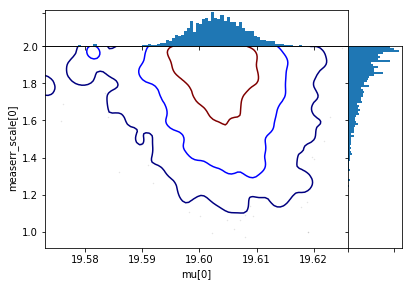

In [65]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


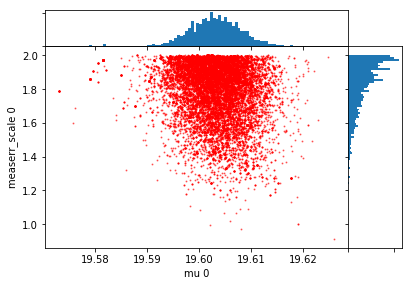

In [66]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


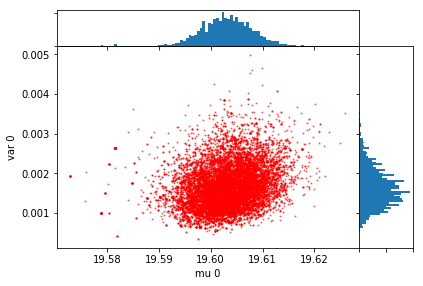

In [69]:
sample.plot_2dpdf('mu', 'var', doShow=True)

Plotting 2d PDF w KDE


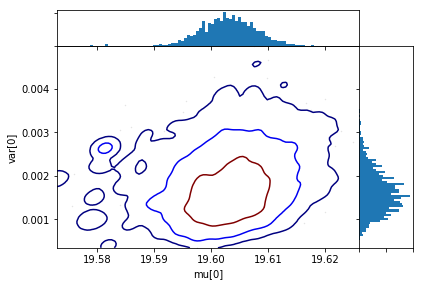

In [68]:
sample.plot_2dkde('mu', 'var', doShow=True)